# WNTR Tutorial

## Imports
Import WNTR and additional Python packages that are needed for the tutorial
- Numpy is required for define logic operations
- Scipy is required to define lognormal fragility curves
- NetworkX is used to compute topographic metrics
- Geopandas is used to load geospatial data
- Matplotlib is required to create graphics

In [306]:
import numpy as np
from scipy.stats import lognorm
import networkx as nx
import geopandas as gpd
import matplotlib.pylab as plt
import wntr

In [307]:
# The following function is used below to extract public properties and methods of WNTR objects
def dir_public(obj):
    return [name for name in dir(obj) if not name.startswith('_')]

# 1. Water Network Model

The `WaterNetworkModel` object defines the water distribution system and simulation options. The object can be created from an EPANET INP file.

In [308]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')

In [309]:
# Basic description of the model
wn.describe(level=1)

{'Nodes': {'Junctions': 92, 'Tanks': 3, 'Reservoirs': 2},
 'Links': {'Pipes': 117, 'Pumps': 2, 'Valves': 0},
 'Patterns': 5,
 'Curves': {'Pump': 2, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 18}

In [310]:
# Explore properties and methods associated with the WaterNetworkModel
dir_public(wn)

['add_control',
 'add_curve',
 'add_junction',
 'add_pattern',
 'add_pipe',
 'add_pump',
 'add_reservoir',
 'add_source',
 'add_tank',
 'add_valve',
 'assign_demand',
 'control_name_list',
 'controls',
 'convert_controls_to_rules',
 'curve_name_list',
 'curves',
 'describe',
 'fcv_name_list',
 'fcvs',
 'from_dict',
 'from_gis',
 'get_control',
 'get_curve',
 'get_graph',
 'get_link',
 'get_links_for_node',
 'get_node',
 'get_pattern',
 'get_source',
 'gpv_name_list',
 'gpvs',
 'head_pump_name_list',
 'head_pumps',
 'junction_name_list',
 'junctions',
 'link_name_list',
 'links',
 'name',
 'node_name_list',
 'nodes',
 'num_controls',
 'num_curves',
 'num_junctions',
 'num_links',
 'num_nodes',
 'num_patterns',
 'num_pipes',
 'num_pumps',
 'num_reservoirs',
 'num_sources',
 'num_tanks',
 'num_valves',
 'options',
 'pattern_name_list',
 'patterns',
 'pbv_name_list',
 'pbvs',
 'pipe_name_list',
 'pipes',
 'power_pump_name_list',
 'power_pumps',
 'prv_name_list',
 'prvs',
 'psv_name_list',


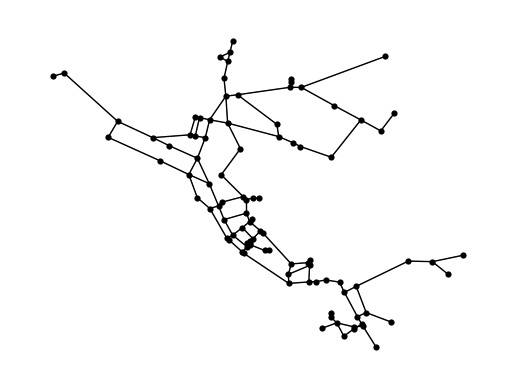

In [311]:
# Basic network graphic
ax = wntr.graphics.plot_network(wn)

## Nodes
Nodes define junctions, tanks, and reservoirs

In [312]:
# Print the names of all junctions, tanks, and reservoirs
print("Node names", wn.node_name_list)

Node names ['10', '15', '20', '35', '40', '50', '60', '601', '61', '101', '103', '105', '107', '109', '111', '113', '115', '117', '119', '120', '121', '123', '125', '127', '129', '131', '139', '141', '143', '145', '147', '149', '151', '153', '157', '159', '161', '163', '164', '166', '167', '169', '171', '173', '177', '179', '181', '183', '184', '185', '187', '189', '191', '193', '195', '197', '199', '201', '203', '204', '205', '206', '207', '208', '209', '211', '213', '215', '217', '219', '225', '229', '231', '237', '239', '241', '243', '247', '249', '251', '253', '255', '257', '259', '261', '263', '265', '267', '269', '271', '273', '275', 'River', 'Lake', '1', '2', '3']


In [313]:
# Print the names of just tanks
print("Tank names", wn.tank_name_list)

Tank names ['1', '2', '3']


In [314]:
# Get a tank object, check its type, print properties and methods
tank = wn.get_node('1')
print(type(tank))
print(dir_public(tank))

<class 'wntr.network.elements.Tank'>
['add_leak', 'bulk_coeff', 'coordinates', 'demand', 'diameter', 'elevation', 'get_volume', 'head', 'init_level', 'initial_quality', 'leak_area', 'leak_demand', 'leak_discharge_coeff', 'leak_status', 'level', 'max_level', 'min_level', 'min_vol', 'mixing_fraction', 'mixing_model', 'name', 'node_type', 'overflow', 'pressure', 'quality', 'remove_leak', 'tag', 'to_dict', 'to_ref', 'vol_curve', 'vol_curve_name']


In [315]:
# Change the max level of a tank
print("Original max level", tank.max_level)
tank.max_level = 10
print("New max level", tank.max_level)

Original max level 9.784080000000001
New max level 10


In [316]:
# Add a junction
wn.add_junction('new_junction', base_demand=0.0, demand_pattern=None, elevation=0.0, coordinates=None, demand_category=None)

In [317]:
# Remove a junction (as a node)
wn.remove_node('new_junction')

## Links
Links define pipes, pumps, and valves

In [318]:
# Print the names of all links
print("Link names", wn.link_name_list)

Link names ['20', '40', '50', '60', '101', '103', '105', '107', '109', '111', '112', '113', '114', '115', '116', '117', '119', '120', '121', '122', '123', '125', '129', '131', '133', '135', '137', '145', '147', '149', '151', '153', '155', '159', '161', '163', '169', '171', '173', '175', '177', '179', '180', '181', '183', '185', '186', '187', '189', '191', '193', '195', '197', '199', '201', '202', '203', '204', '205', '207', '209', '211', '213', '215', '217', '219', '221', '223', '225', '229', '231', '233', '235', '237', '238', '239', '240', '241', '243', '245', '247', '249', '251', '257', '261', '263', '269', '271', '273', '275', '277', '281', '283', '285', '287', '289', '291', '293', '295', '297', '299', '301', '303', '305', '307', '309', '311', '313', '315', '317', '319', '321', '323', '325', '329', '330', '333', '10', '335']


In [319]:
# Print the names of just head pumps
print("Head pump names", wn.head_pump_name_list)

Head pump names ['10', '335']


In [320]:
# Get the name of links connected to a specific node
connected_links = wn.get_links_for_node('229')
print('Links connected to node 229 =', connected_links)

Links connected to node 229 = ['261', '263', '271']


In [321]:
# Get a pipe object, check its type, print properties and methods
pipe = wn.get_link('105')
print(type(pipe))
print(dir_public(pipe))

<class 'wntr.network.elements.Pipe'>
['bulk_coeff', 'check_valve', 'cv', 'diameter', 'end_node', 'end_node_name', 'flow', 'friction_factor', 'headloss', 'initial_setting', 'initial_status', 'length', 'link_type', 'minor_loss', 'name', 'quality', 'reaction_rate', 'roughness', 'setting', 'start_node', 'start_node_name', 'status', 'tag', 'to_dict', 'to_ref', 'velocity', 'vertices', 'wall_coeff']


In [322]:
# Change the diameter of a pipe
print("Original diameter", pipe.diameter)
pipe.diameter = 10
print("New diameter", pipe.diameter)

Original diameter 0.30479999999999996
New diameter 10


In [323]:
# Add a pipe
wn.add_pipe(name="new_pipe", start_node_name="10", end_node_name="123", length=304.8, diameter=0.3048, roughness=100, minor_loss=0.0, initial_status='OPEN', check_valve=False)

In [324]:
# Remove a pipe
wn.remove_link("new_pipe")

## Demands and Patterns
Junctions can have multiple demands which are stored as Timeseries objects in a `demand_timeseries_list`. Each Timeseries contains a base value, pattern, and category.  Patterns contain multiliers and the pattern timestep.  

The following illustrates how to
* Compute expected demand (which accounts for base demand, demand patterns, and demand multiplier)
* Compute average expected demand (average value for a 24 hour period, also accounts for base demand, demand patterns, and demand multiplier)
* Add demands to a junction
* Modify demand base value and pattern
* Remove demands from a junction
* Plot expected and simulated demands

In [414]:
# Compute expected demand
expected_demand = wntr.metrics.expected_demand(wn)
expected_demand.head()

,10,15,20,35,40,50,60,601,61,101,...,257,259,261,263,265,267,269,271,273,275
0.0,0.0,0.039116,0.0,0.103279,0.0,0.0,0.0,0.0,0.0,0.016059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600.0,0.0,0.039116,0.0,0.107632,0.0,0.0,0.0,0.0,0.0,0.023249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7200.0,0.0,0.039116,0.0,0.108452,0.0,0.0,0.0,0.0,0.0,0.017497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10800.0,0.0,0.039116,0.0,0.108452,0.0,0.0,0.0,0.0,0.0,0.017257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14400.0,0.0,0.039116,0.0,0.112995,0.0,0.0,0.0,0.0,0.0,0.009108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


10    0.000000
15    0.016666
20    0.000000
35    0.108389
40    0.000000
dtype: float64


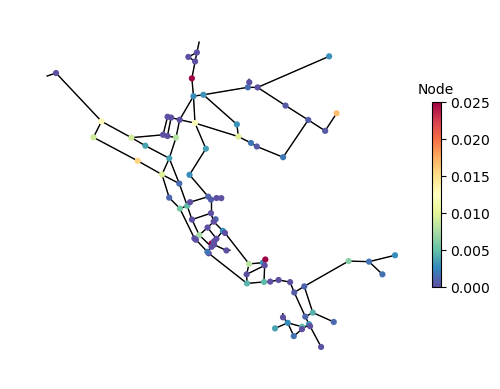

In [326]:
# Compute and plot average expected demand and 
AED = wntr.metrics.average_expected_demand(wn)
print(AED.head())
ax = wntr.graphics.plot_network(wn, node_attribute=AED, node_range=(0,0.025))

Index(['10', '20', '40', '50', '60', '601', '61', '120', '129', '164', '169',
       '173', '179', '181', '183', '184', '187', '195', '204', '206', '208',
       '241', '249', '257', '259', '261', '263', '265', '267', '269', '271',
       '273', '275'],
      dtype='object')


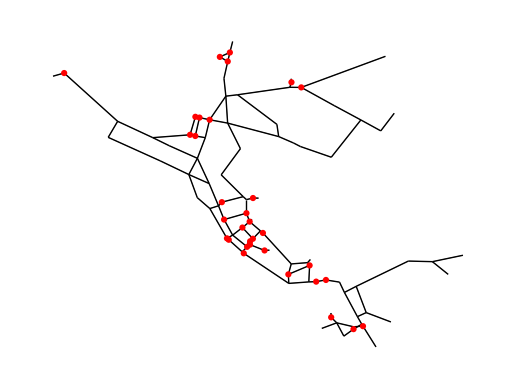

In [413]:
# Identify junctions with zero demand
zero_demand = AED[AED == 0].index
print(zero_demand)
ax = wntr.graphics.plot_network(wn, node_attribute=list(zero_demand))

In [411]:
# Get the demands on Junction 15
junction = wn.get_node('15')
junction.demand_timeseries_list

<Demands: [<TimeSeries: base_value=6.30901964e-05, pattern_name='3', category='None'>]>

In [329]:
# Get the pattern associated with the demand
pattern = wn.get_pattern(junction.demand_timeseries_list[0].pattern_name)
pattern

<Pattern '3', multipliers=array([620., 620., 620., 620., 620., 360., 360.,   0.,   0.,   0.,   0., 360., 360., 360., 360., 360.,   0.,   0.,   0.,   0.,   0.,   0., 360., 360.])>

In [330]:
# Modify the base value of the demand
junction.demand_timeseries_list[0].base_value = 0.005

# Add a pattern
wn.add_pattern('New', [1,1,1,0,0,0,1,0,0.5,0.5,0.5,1])

# Modify the pattern of the demand
junction.demand_timeseries_list[0].pattern_name = "New"
print(junction.demand_timeseries_list)

<Demands: [<TimeSeries: base_value=0.005, pattern_name='New', category='None'>]>


In [331]:
# Add a demand
junction.add_demand(base=0.015, pattern_name='1')
print(junction.demand_timeseries_list)

<Demands: [<TimeSeries: base_value=0.005, pattern_name='New', category='None'>, <TimeSeries: base_value=0.015, pattern_name='1', category='None'>]>


<Axes: >

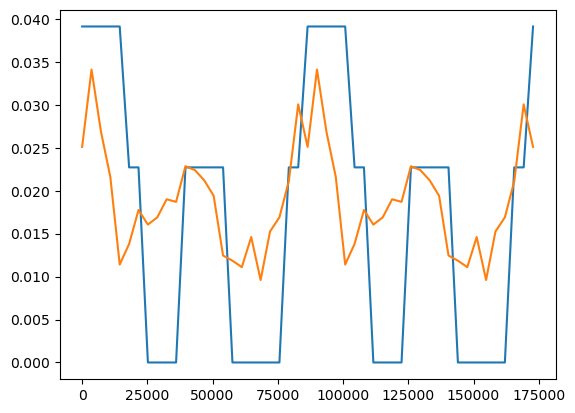

In [332]:
# Plot original and modified expected demands
new_expected_demand = wntr.metrics.expected_demand(wn) 

plt.figure()
ax = expected_demand.loc[0:48*3600, "15"].plot()
new_expected_demand.loc[0:48*3600, "15"].plot(ax=ax)

## Curves
Curves define pump head curves, tank volume curves, and pump efficiency curves.  The following example illustrates how to work with pump head curves and tank volume curves.

<class 'wntr.network.elements.HeadPump'>


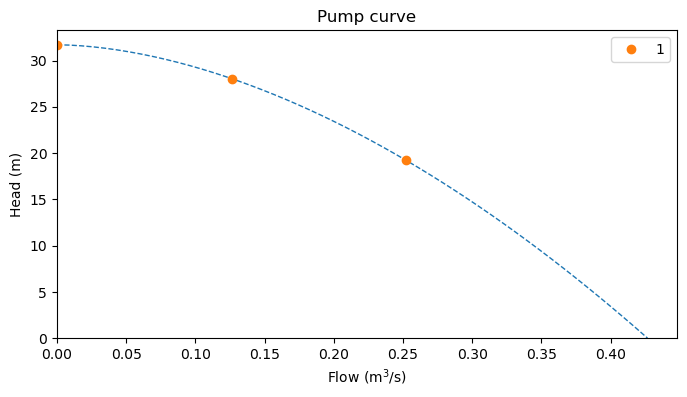

In [333]:
# Get a head pump object and plot the head pump curve
pump = wn.get_link('10')
print(type(pump))
ax = wntr.graphics.plot_pump_curve(pump)

In [334]:
# Get the head curve and print the points
pump_curve_name = pump.pump_curve_name
curve = wn.get_curve(pump_curve_name)
curve.points

[(0.0, 31.6992), (0.1261803928, 28.041600000000003), (0.2523607856, 19.2024)]


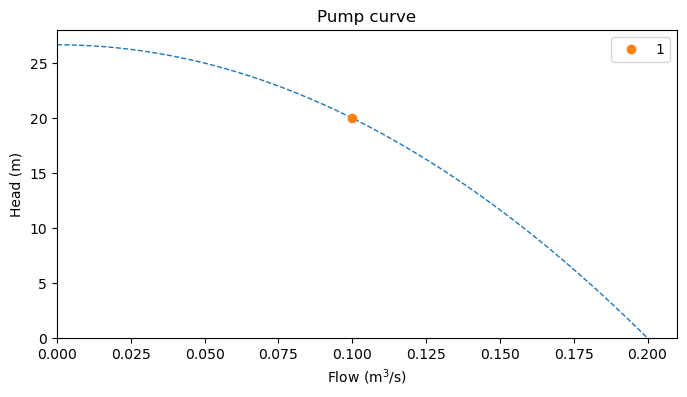

In [410]:
# Modify the curve points and replot the pump curve
curve.points = [(0.10, 20)]
ax = wntr.graphics.plot_pump_curve(pump)

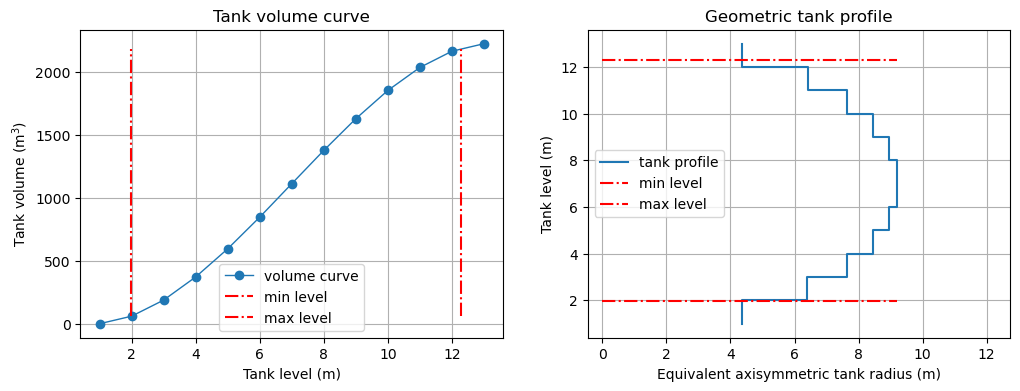

In [336]:
# Add a tank volume curve to the model and assign it to a tank
wn.add_curve('new_tank_curve', 'VOLUME', [
   (1,  0),
   (2,  60),
   (3,  188),
   (4,  372),
   (5,  596),
   (6,  848),
   (7,  1114),
   (8,  1379),
   (9,  1631),
   (10, 1856),
   (11, 2039),
   (12, 2168),
   (13, 2228)])
tank = wn.get_node('2')
tank.vol_curve_name = 'new_tank_curve'
ax = wntr.graphics.plot_tank_volume_curve(tank)

## Controls

Controls define the rules to operate pipes, pumps, and valves.

In [337]:
# Get a list of control names
wn.control_name_list

['control 1',
 'control 2',
 'control 3',
 'control 4',
 'control 5',
 'control 6',
 'control 7',
 'control 8',
 'control 9',
 'control 10',
 'control 11',
 'control 12',
 'control 13',
 'control 14',
 'control 15',
 'control 16',
 'control 17',
 'control 18']

In [338]:
# Get a specific control object
control = wn.get_control('control 18')
print(control)

IF TANK 1 LEVEL ABOVE 5.821680000000001 THEN PIPE 330 STATUS IS OPEN PRIORITY 3


In [339]:
# Modify the control priority
control.update_priority(1)
print(control)

IF TANK 1 LEVEL ABOVE 5.821680000000001 THEN PIPE 330 STATUS IS OPEN PRIORITY 1


In [340]:
# Add a time based pump control
pump = wn.get_link('10')
action = wntr.network.controls.ControlAction(pump, 'status', 1)
condition = wntr.network.controls.SimTimeCondition(wn, '=', '121:00:00')
control = wntr.network.controls.Control(condition, action, name='new_control')
wn.add_control('NewControl', control)

In [341]:
# Remove a control
wn.remove_control('NewControl')

In [342]:
# Convert controls to rules
wn.convert_controls_to_rules()
for name, controls in wn.controls():
    print(name, controls)

control_1_Rule IF SYSTEM TIME IS 01:00:00 THEN PUMP 10 STATUS IS OPEN PRIORITY 3
control_2_Rule IF SYSTEM TIME IS 15:00:00 THEN PUMP 10 STATUS IS CLOSED PRIORITY 3
control_3_Rule IF SYSTEM TIME IS 25:00:00 THEN PUMP 10 STATUS IS OPEN PRIORITY 3
control_4_Rule IF SYSTEM TIME IS 39:00:00 THEN PUMP 10 STATUS IS CLOSED PRIORITY 3
control_5_Rule IF SYSTEM TIME IS 49:00:00 THEN PUMP 10 STATUS IS OPEN PRIORITY 3
control_6_Rule IF SYSTEM TIME IS 63:00:00 THEN PUMP 10 STATUS IS CLOSED PRIORITY 3
control_7_Rule IF SYSTEM TIME IS 73:00:00 THEN PUMP 10 STATUS IS OPEN PRIORITY 3
control_8_Rule IF SYSTEM TIME IS 87:00:00 THEN PUMP 10 STATUS IS CLOSED PRIORITY 3
control_9_Rule IF SYSTEM TIME IS 97:00:00 THEN PUMP 10 STATUS IS OPEN PRIORITY 3
control_10_Rule IF SYSTEM TIME IS 111:00:00 THEN PUMP 10 STATUS IS CLOSED PRIORITY 3
control_11_Rule IF SYSTEM TIME IS 121:00:00 THEN PUMP 10 STATUS IS OPEN PRIORITY 3
control_12_Rule IF SYSTEM TIME IS 135:00:00 THEN PUMP 10 STATUS IS CLOSED PRIORITY 3
control_13

## Model I/O
Water network models can be converted to/from dictionaries, NetworkX graphs, Geopandas GeoDataFrames, and EPANET INP files, JSON files, and GeoJSON files

In [343]:
# Convert the WaterNetworkModel to/from a dictionary
wn_dict = wn.to_dict()
wn2 = wntr.network.from_dict(wn_dict)

In [344]:
# Convert the WaterNetworkModel to a graph
G = wntr.network.to_graph(wn)

In [345]:
# Convert the WaterNetworkModel to a collection of GeoDataFrames
wn_gis = wntr.network.to_gis(wn)
wn2 = wntr.network.from_gis(wn_gis)

In [346]:
# Create an INP file from the WaterNetworkModel
wntr.network.io.write_inpfile(wn, 'Net3_modified.inp', units='LPS')
wn2 = wntr.network.read_inpfile('Net3_modified.inp') 

In [347]:
# Create a JSON file from the WaterNetworkModel
wntr.network.write_json(wn, 'Net3.json')
wn2 = wntr.network.read_json('Net3.json')

In [348]:
# Create GeoJSON files from the WaterNetworkModel
wntr.network.write_geojson(wn, 'Net3')
geojson_files = {'junctions': 'Net3_junctions.geojson',
                 'tanks': 'Net3_tanks.geojson',
                 'reservoirs': 'Net3_reservoirs.geojson',
                 'pipes': 'Net3_pipes.geojson',
                 'pumps': 'Net3_pumps.geojson'}
wn2 = wntr.network.read_geojson(geojson_files)

## Queries
Query methods return attributes of nodes and links.  Logical operations (like >, =) can be used to return a subset of attributes that meet specific criteria.

In [408]:
# Return all pipe diameters
all_pipe_diameters = wn.query_link_attribute('diameter')
all_pipe_diameters.head()

20     2.5146
40     2.5146
50     2.5146
60     0.6096
101    0.4572
dtype: float64

In [407]:
# Return pipes diameters > 12 inches
large_pipe_diameters = wn.query_link_attribute('diameter', np.greater, 12*0.0254)
large_pipe_diameters.head()

20     2.5146
40     2.5146
50     2.5146
60     0.6096
101    0.4572
dtype: float64

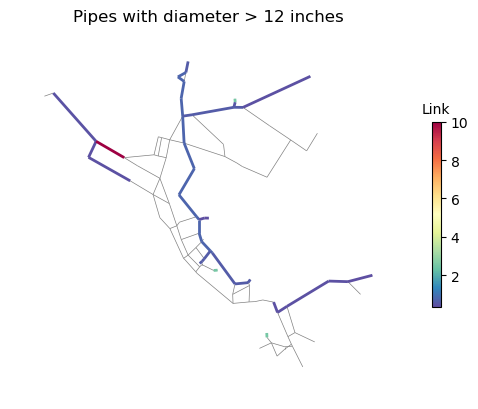

In [351]:
# Plot large pipes
ax = wntr.graphics.plot_network(wn, link_attribute=large_pipe_diameters, node_size=0, 
                           link_width=2, title="Pipes with diameter > 12 inches")

## Loops and generators
Loops and generators are commonly used to modify network components or run stochastic simulations

In [352]:
# Loop over tank names and objects with a generator
for name, tank in wn.tanks():
    print("Max level for tank", name, "=", tank.max_level)

Max level for tank 1 = 10
Max level for tank 2 = 12.28344
Max level for tank 3 = 10.820400000000001


In [353]:
# Loop over tank names and then get the associated tank object
for name in wn.tank_name_list:
    tank = wn.get_node(name)
    print("Max level for tank", name, "=", tank.max_level)

Max level for tank 1 = 10
Max level for tank 2 = 12.28344
Max level for tank 3 = 10.820400000000001


## Coordinates
Node coordinates can be obtained using a node query.  Node coordinates can also be modified using functions in `wntr.morph`

In [354]:
# Get node coordinates
coords = wn.query_node_attribute('coordinates')
coords

10         (9.0, 27.85)
15       (38.68, 23.76)
20       (29.44, 26.91)
35       (25.46, 10.52)
40        (27.02, 9.81)
              ...      
River    (24.15, 31.06)
Lake       (8.0, 27.53)
1         (27.46, 9.84)
2         (32.99, 3.45)
3        (29.41, 27.27)
Length: 97, dtype: object

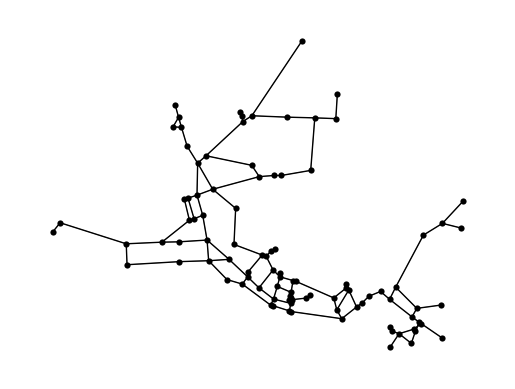

In [355]:
# Rotate node coordinates counterclockwise by 30 degrees
wn_rotated = wntr.morph.rotate_node_coordinates(wn, 30)
ax = wntr.graphics.plot_network(wn_rotated)

## Pipe breaks and leaks
Pipes can be split to add a node, or broken into two none conntected segments using the `split_pipe` and `break_pipe` functions.  By default these functions return a copy of the network model.

In [356]:
# Split pipe 123 and add a leak to the new node
wn2 = wntr.morph.split_pipe(wn, '123', '123_B', '123_node')
leak_node = wn2.get_node('123_node')
leak_node.add_leak(wn2, area=0.05, start_time=2*3600, end_time=12*3600)

In [357]:
# Break pipe 121
wn3 = wntr.morph.break_pipe(wn2, '121', '121_B', '121_node', '121B_node')

# 2. Hydraulic and Water Quality Simulations

WNTR includes two simulators: the `EpanetSimulator` and the `WNTRSimulator`.  Both include the ability to run pressure dependent demand (PDD) or demand-driven (DD) hydraulic simulation.  Only the EpanetSimulator runs water quality simulations.

In [358]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')

## Simulation options

In [359]:
# Print the WaterNetworkModel options
wn.options

Options(time=TimeOptions(duration=604800.0, hydraulic_timestep=3600, quality_timestep=300, rule_timestep=360, pattern_timestep=3600, pattern_start=0.0, report_timestep=3600, report_start=0.0, start_clocktime=0.0, statistic='NONE', pattern_interpolation=False), hydraulic=HydraulicOptions(headloss='H-W', hydraulics=None, hydraulics_filename=None, viscosity=1.0, specific_gravity=1.0, pattern='1', demand_multiplier=1.0, demand_model='DDA', minimum_pressure=0.0, required_pressure=0.07, pressure_exponent=0.5, emitter_exponent=0.5, trials=40, accuracy=0.001, unbalanced='CONTINUE', unbalanced_value=10, checkfreq=2, maxcheck=10, damplimit=0.0, headerror=0.0, flowchange=0.0, inpfile_units='GPM', inpfile_pressure_units=None), report=ReportOptions(pagesize=0, report_filename=None, status='YES', summary='NO', energy='NO', nodes=False, links=False, report_params={'elevation': False, 'demand': True, 'head': True, 'pressure': True, 'quality': True, 'length': False, 'diameter': False, 'flow': True, 've

In [360]:
# Change the simulation duration to 4 days
wn.options.time.duration = 4*24*3600

In [361]:
# Change the simulation to use pressure dependent hydraulic analysis
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 20 
wn.options.hydraulic.minimum_pressure = 2

## EPANET and WNTR Simulators

In [362]:
# Simulate hydraulics using EPANET
sim = wntr.sim.EpanetSimulator(wn)
results_EPANET = sim.run_sim()

In [363]:
# Simulate hydraulics using the WNTRSimulator
sim = wntr.sim.WNTRSimulator(wn)
results_WNTR = sim.run_sim()

## Simulation results

<Axes: title={'center': 'Tank level'}>

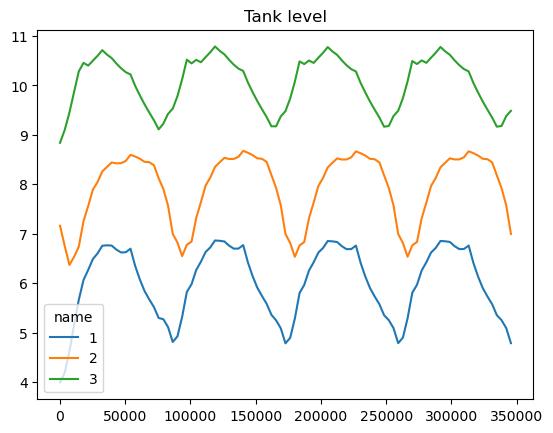

In [364]:
# Plot timeseries of tank levels
tank_levels = results_EPANET.node['pressure'].loc[:,wn.tank_name_list]
tank_levels.plot(title='Tank level')

<Axes: title={'center': 'Pump flowrate'}>

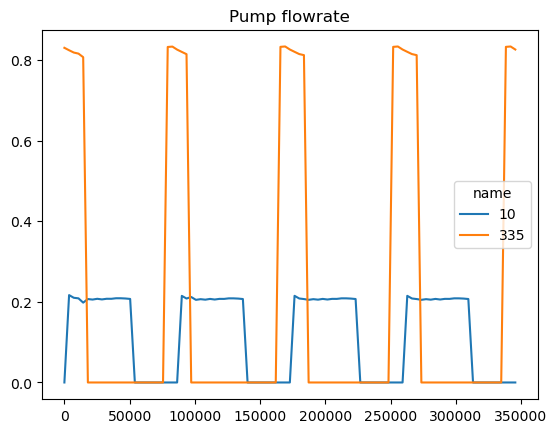

In [365]:
# Plot timeseries of pump flowrates
pump_flowrates = results_EPANET.link['flowrate'].loc[:,wn.pump_name_list]
pump_flowrates.plot(title='Pump flowrate')

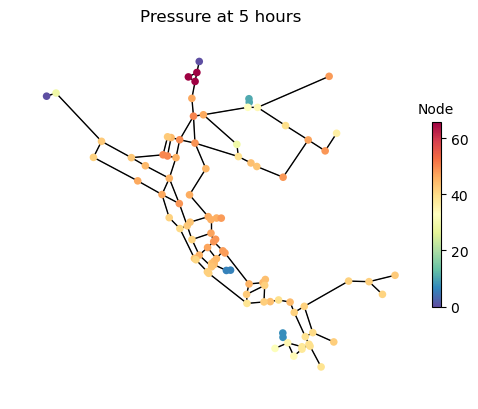

In [366]:
# Plot pressure at hour 5 on the network
pressure_at_5hr = results_EPANET.node['pressure'].loc[5*3600, :]
ax = wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=30, title='Pressure at 5 hours')

## Reset initial conditions
Reset initial values, including simulation time, tank head, reservoir head, pipe status, pump status, and valve status.  This is required when using the WNTRSimulator multiple simulations. Note, the EPANETSimulator is autoamtically reset.

In [367]:
wn.reset_initial_values()

# 3. Resilience Metrics

WNTR includes a wide range of metrics that can be used to compute resilience and related properties.

In [368]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')

## Topographic
Topographic metrics describe the physical layout of the system. Note that some metrics require an undirected graph or a graph with a single edge between two nodes.

In [369]:
G = wn.to_graph() # directed multigraph
uG = G.to_undirected() # undirected multigraph
sG = nx.Graph(uG) # undirected simple graph (single edge between two nodes)
betweenness_centrality = nx.betweenness_centrality(sG)

## Hydraulic
Hydraulic metrics are based on flow, demand, and/or pressure

In [370]:
# Run a pressure dependent hydraulic simulation
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.required_pressure = 50 # The required pressure is set higher to create a scenario where not all demands are not met

sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

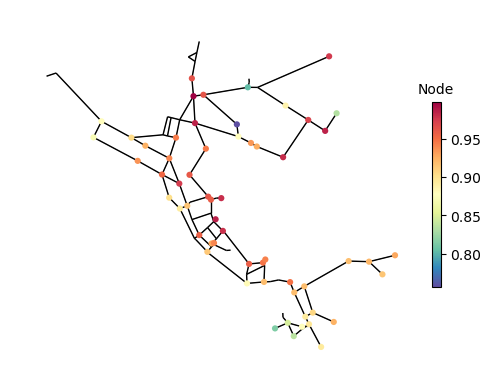

In [371]:
# Compute water service availability, defined as the ratio of delivered demand to the expected demand. 
expected_demand = wntr.metrics.expected_demand(wn)
demand = results.node['demand'].loc[:,wn.junction_name_list]
wsa = wntr.metrics.water_service_availability(expected_demand.sum(axis=0), demand.sum(axis=0))
ax = wntr.graphics.plot_network(wn, node_attribute=wsa)

## Water Quality
Water quality metrics are based on the concentration or water age.

In [372]:
# Compute water age using the last 48 hours of a water quality simulation
wn.options.quality.parameter = 'AGE'
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

age = results.node['quality']
age_last_48h = age.loc[age.index[-1]-48*3600:age.index[-1]]
average_age = age_last_48h.mean()/3600 # convert to hours

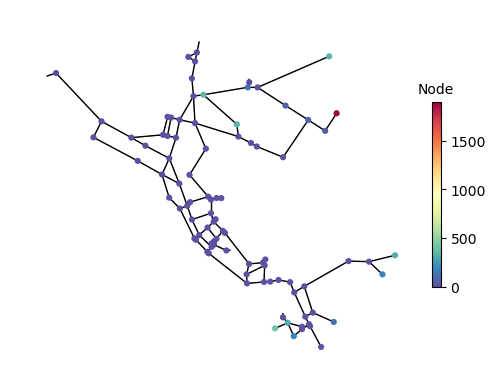

In [373]:
# Compute the population that is impacted by water age greater than 24 hours
pop = wntr.metrics.population(wn)
threshold = 24
pop_impacted = wntr.metrics.population_impacted(pop, average_age, np.greater, threshold)
ax = wntr.graphics.plot_network(wn, node_attribute=pop_impacted)

# 4. Fragility Curves

Fragility curves define the probability of exceeding a given damage state as a function of environmental change.

In [374]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')

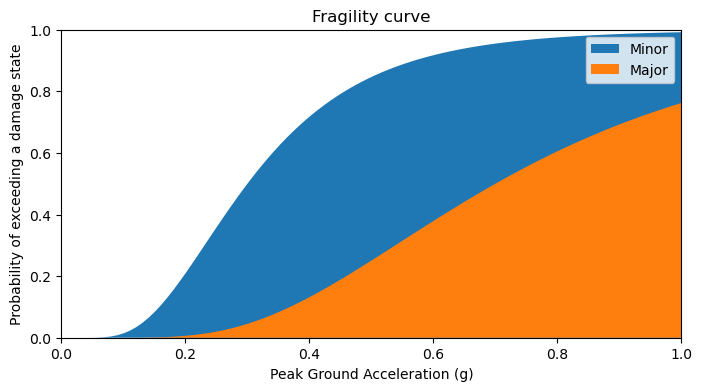

In [375]:
FC = wntr.scenario.FragilityCurve()
FC.add_state('Minor', 1, {'Default': lognorm(0.5,scale=0.3)})
FC.add_state('Major', 2, {'Default': lognorm(0.5,scale=0.7)})
ax = wntr.graphics.plot_fragility_curve(FC, xlabel='Peak Ground Acceleration (g)')

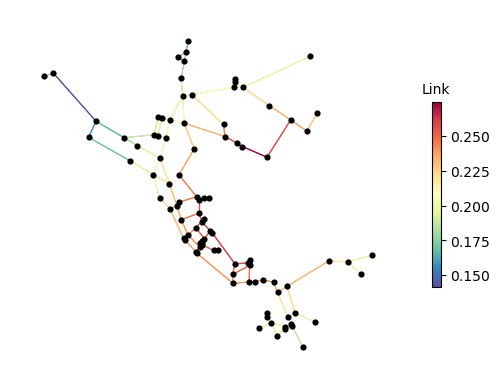

In [376]:
# Model peak ground acceleration from a magnitude 6.5 earthquake, assigning values to pipes.
wn = wntr.morph.scale_node_coordinates(wn, 1000)
epicenter = (32000,15000) # x,y location
magnitude = 6.5 # Richter scale
depth = 10000 # m, shallow depth
earthquake = wntr.scenario.Earthquake(epicenter, magnitude, depth)
distance = earthquake.distance_to_epicenter(wn, element_type=wntr.network.Pipe)
pga = earthquake.pga_attenuation_model(distance)
ax = wntr.graphics.plot_network(wn, link_attribute=pga)

In [377]:
# Sample the failure probability and damage states for each pipe
failure_probability = FC.cdf_probability(pga)
damage_state = FC.sample_damage_state(failure_probability)

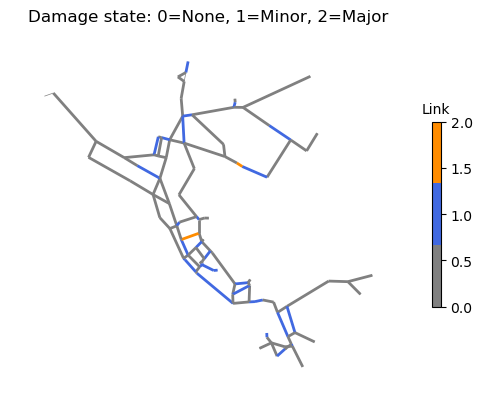

In [378]:
# Plot damage state (converted to numeric values) on the network
priority_map = FC.get_priority_map()
damage_value = damage_state.map(priority_map)
custom_cmp = wntr.graphics.custom_colormap(3, ['grey', 'royalblue', 'darkorange'])
ax = wntr.graphics.plot_network(wn, link_attribute=damage_value,
    node_size=0, link_width=2, link_cmap=custom_cmp,
    title='Damage state: 0=None, 1=Minor, 2=Major')

# 5. Network Skeletonization

Network skeletonization reduces the size of a water network model with minimal impact on system behavior. 

The skeletonization process retains all tanks, reservoirs, valves, and pumps, along with all junctions and pipes that are associated with controls. Junction demands and demand patterns are retained in the skeletonized model. Merged pipes are assigned equivalent properties for diameter, length, and roughness to approximate the updated system behavior. Pipes that are less than or equal to a user-defined pipe diameter threshold are candidates for removal based on branch triming, series and parallel pipe merge.

In [379]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')
wn.describe(level=1)

{'Nodes': {'Junctions': 92, 'Tanks': 3, 'Reservoirs': 2},
 'Links': {'Pipes': 117, 'Pumps': 2, 'Valves': 0},
 'Patterns': 5,
 'Curves': {'Pump': 2, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 18}

In [380]:
# Skeletonize the network using a 12 inch pipe diameter threshold
skel_wn = wntr.morph.skeletonize(wn, 12*0.0254)
skel_wn.describe(level=1)

{'Nodes': {'Junctions': 67, 'Tanks': 3, 'Reservoirs': 2},
 'Links': {'Pipes': 92, 'Pumps': 2, 'Valves': 0},
 'Patterns': 5,
 'Curves': {'Pump': 2, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 18}

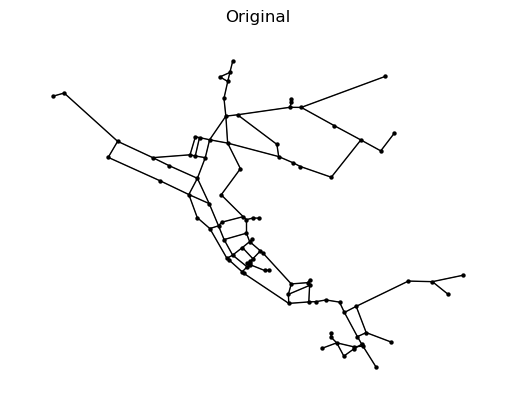

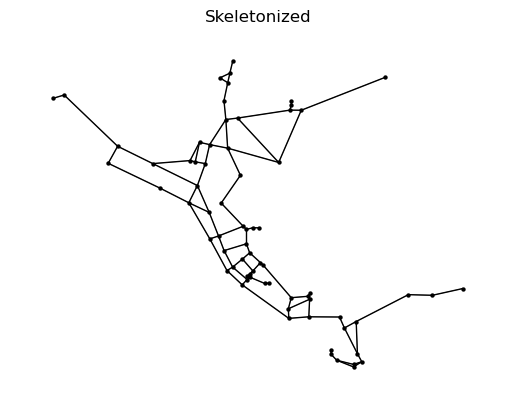

In [381]:
# Plot the original and skeletonized networks
ax = wntr.graphics.plot_network(wn, node_size=10, title='Original')
ax = wntr.graphics.plot_network(skel_wn, node_size=10, title='Skeletonized')

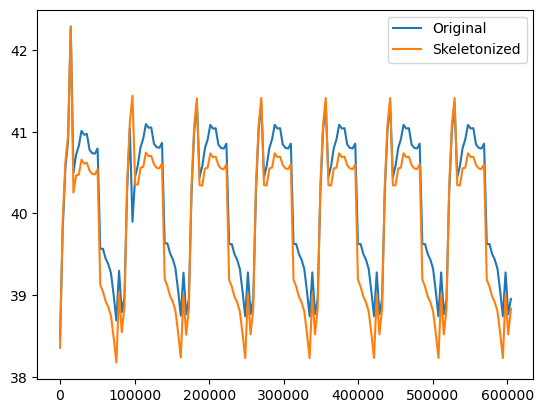

In [382]:
# Simulate hydraulics on the original and skeletonized models and plot average pressure
sim = wntr.sim.EpanetSimulator(wn)
results_original = sim.run_sim()

sim = wntr.sim.EpanetSimulator(skel_wn)
results_skel = sim.run_sim()

ax = results_original.node['pressure'].mean(axis=1).plot(label='Original')
ax = results_skel.node['pressure'].mean(axis=1).plot(ax=ax, label='Skeletonized')
plt.legend()

# 6. Valve Segmentation

Valve segmentation groups links and nodes into segments based on the location of isolation valves. 

In [401]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net3.inp')

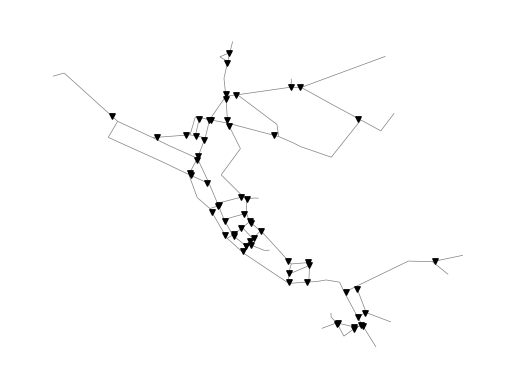

In [402]:
# Create a N-2 strategic valve layer
valve_layer = wntr.network.generate_valve_layer(wn, 'strategic', 2)
ax = wntr.graphics.plot_valve_layer(wn, valve_layer, add_colorbar=False)

In [406]:
# Identify nodes and links that are in each valve segment
G = wn.to_graph()
node_segments, link_segments, seg_sizes = wntr.metrics.topographic.valve_segments(G, valve_layer)
seg_sizes.head()

,link,node
16,13,12
11,11,12
30,9,8
21,9,8
26,7,6


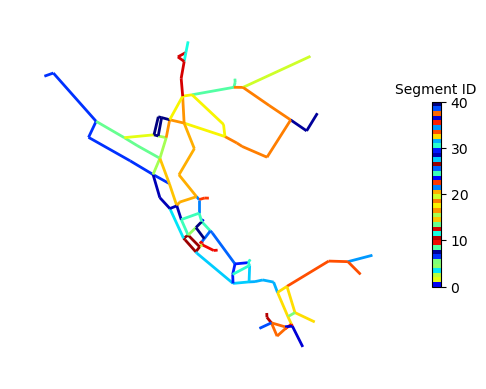

In [386]:
# Plot segments
N = seg_sizes.shape[0] # number of segments
cmap = wntr.graphics.random_colormap(N) # random color map helps visualize segments
ax = wntr.graphics.plot_network(wn, link_attribute=link_segments, node_size=0, link_width=2, link_range=[0,N],  link_cmap=cmap, link_colorbar_label='Segment ID')

# 7. Geospatial Capabilities
Geospatial data can be used within WNTR to build a WaterNetworkModel, associate geospatial data with nodes and links, and save simualtion results to GIS compatible files.

In [387]:
# Create water network model from an INP file
wn = wntr.network.WaterNetworkModel('../networks/Net1.inp')

In [388]:
# Convert a WaterNetworkModel to a collection of GeoDataFrames in EPSG:4326 coordinates
wn_gis = wntr.network.to_gis(wn, crs='EPSG:4326')
wn_gis.pipes.head()

,link_type,start_node_name,end_node_name,check_valve,diameter,initial_status,length,minor_loss,roughness,geometry
10,Pipe,10,11,False,0.4572,Open,3209.544,0.0,100.0,"LINESTRING (20.00000 70.00000, 30.00000 70.00000)"
11,Pipe,11,12,False,0.3556,Open,1609.344,0.0,100.0,"LINESTRING (30.00000 70.00000, 50.00000 70.00000)"
12,Pipe,12,13,False,0.2540,Open,1609.344,0.0,100.0,"LINESTRING (50.00000 70.00000, 70.00000 70.00000)"
21,Pipe,21,22,False,0.2540,Open,1609.344,0.0,100.0,"LINESTRING (30.00000 40.00000, 50.00000 40.00000)"
22,Pipe,22,23,False,0.3048,Open,1609.344,0.0,100.0,"LINESTRING (50.00000 40.00000, 70.00000 40.00000)"


In [389]:
# Build a WaterNetworkModel from a collection of GeoDataFrames. 
# Note that models built from GeoDataFrames will not contain patterns, curves, sources, controls, and options
wn2 = wntr.network.from_gis(wn_gis)

In [390]:
# Load hydrant data
hydrant_data = gpd.read_file('../data/Net1_hydrant_data.geojson') 
print(hydrant_data.crs)
hydrant_data.head()

EPSG:4326


,demand,geometry
0,5000,POINT (48.20000 37.20000)
1,1500,POINT (71.80000 68.30000)
2,8000,POINT (51.20000 71.10000)


## Snap data
The `snap` function is used to find the nearest point or line to a set of points. 

In [391]:
# Snap hydrants to junctions
snapped_to_junctions = wntr.gis.snap(hydrant_data, wn_gis.junctions, tolerance=5.0)
snapped_to_junctions.head()

C:\Users\kaklise\Projects\src\EPA\WNTR\wntr\gis\geospatial.py:94: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  closest["snap_distance"] = closest.geometry.distance(gpd.GeoSeries(closest.points, crs=crs))


,node,snap_distance,geometry
0,22,3.328663,POINT (50.00000 40.00000)
1,13,2.475884,POINT (70.00000 70.00000)
2,12,1.627882,POINT (50.00000 70.00000)


In [392]:
# Load demographic data associated with census block groups
demographic_data = gpd.read_file('../data/Net1_demographic_data.geojson') 
demographic_data.head()

,mean_income,mean_age,population,geometry
0,63326.0,35.0,3362.0,"POLYGON ((41.67813 82.75023, 41.98596 60.85779..."
1,78245.0,31.0,5618.0,"POLYGON ((23.21084 40.19160, 22.99063 27.71777..."
2,91452.0,40.0,5650.0,"POLYGON ((22.99063 27.71777, 61.93720 16.36165..."
3,54040.0,39.0,5546.0,"POLYGON ((61.93720 16.36165, 22.99063 27.71777..."
4,26135.0,38.0,5968.0,"POLYGON ((61.93720 16.36165, 64.04456 22.10119..."


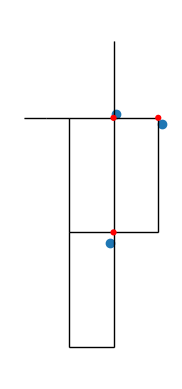

In [393]:
# Plot results
ax = hydrant_data.plot()
ax = wntr.graphics.plot_network(wn, node_attribute=snapped_to_junctions['node'].to_list(), ax=ax)

## Intersect data
The `intersect` function is used to find the intersection between geometries.

In [394]:
# Intersect junctions with census block groups, extract mean income
junction_demographics = wntr.gis.intersect(wn_gis.junctions, demographic_data, 'mean_income')
junction_demographics.head()

,intersections,values,n,sum,min,max,mean
10,[0],[63326.0],1,63326.0,63326.0,63326.0,63326.0
11,[0],[63326.0],1,63326.0,63326.0,63326.0,63326.0
12,[5],[57620.0],1,57620.0,57620.0,57620.0,57620.0
13,[5],[57620.0],1,57620.0,57620.0,57620.0,57620.0
21,[3],[54040.0],1,54040.0,54040.0,54040.0,54040.0


In [395]:
# Intersect pipes with census block groups, extract mean income
pipe_demographics = wntr.gis.intersect(wn_gis.pipes, demographic_data, 'mean_income')
pipe_demographics.head()

C:\Users\kaklise\Projects\src\EPA\WNTR\wntr\gis\geospatial.py:254: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  A_length = A.length
C:\Users\kaklise\Projects\src\EPA\WNTR\wntr\gis\geospatial.py:259: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  val = float(B_geom[B_value])
C:\Users\kaklise\Projects\src\EPA\WNTR\wntr\gis\geospatial.py:263: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  A_clip_length = A_clip.length
C:\Users\kaklise\Projects\src\EPA\WNTR\wntr\gis\geospatial.py:259: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) ins

,intersections,values,n,sum,min,max,mean,weighted_mean
10,[0],[63326.0],1,63326.0,63326.0,63326.0,63326.0,63326.000000
11,"[0, 5]","[63326.0, 57620.0]",2,120946.0,57620.0,63326.0,60473.0,61002.920197
12,[5],[57620.0],1,57620.0,57620.0,57620.0,57620.0,57620.000000
21,[3],[54040.0],1,54040.0,54040.0,54040.0,54040.0,54040.000000
22,"[3, 6]","[54040.0, 44871.0]",2,98911.0,44871.0,54040.0,49455.5,47067.894876


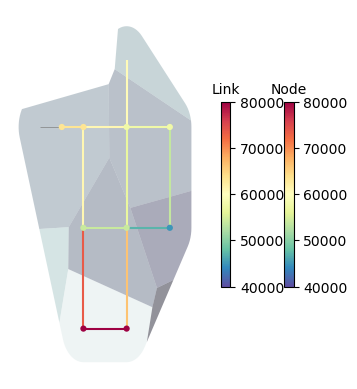

In [396]:
# Plot results
ax = demographic_data.plot(column='mean_income', alpha=0.5, cmap='bone', vmin=10000, vmax=100000)
ax = wntr.graphics.plot_network(wn, node_attribute=junction_demographics['mean'], link_attribute=pipe_demographics['weighted_mean'], link_width=1.5, node_range=[40000,80000], 
                                link_range=[40000,80000], ax=ax)

## Write analysis results to GIS files
In addition to the node and link attributes stored in the `WaterNetworkGIS` object, additional analysis results can be stored and saved to GIS compatible files.

In [397]:
# Compute betweenness centrality and add it to the WaterNetworkGIS object
G = wn.to_graph() # directed multigraph
uG = G.to_undirected() # undirected multigraph
sG = nx.Graph(uG) # undirected simple graph (single edge between two nodes)
betweenness_centrality = nx.betweenness_centrality(sG)

wn_gis.add_node_attributes(betweenness_centrality, 'betweenness_centrality')
wn_gis.junctions.head()

,node_type,elevation,initial_quality,geometry,betweenness_centrality
10,Junction,216.408,0.0005,POINT (20.00000 70.00000),0.200000
11,Junction,216.408,0.0005,POINT (30.00000 70.00000),0.404444
12,Junction,213.360,0.0005,POINT (50.00000 70.00000),0.417037
13,Junction,211.836,0.0005,POINT (70.00000 70.00000),0.044444
21,Junction,213.360,0.0005,POINT (30.00000 40.00000),0.231852


In [398]:
# Run a hydraulic simulation and store average flowrate to the WaterNetworkGIS object
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
flowrate = results.link['flowrate'].mean()

wn_gis.add_link_attributes(flowrate, 'flowrate')
wn_gis.pipes.head()

,link_type,start_node_name,end_node_name,check_valve,diameter,initial_status,length,minor_loss,roughness,geometry,flowrate
10,Pipe,10,11,False,0.4572,Open,3209.544,0.0,100.0,"LINESTRING (20.00000 70.00000, 30.00000 70.00000)",0.069037
11,Pipe,11,12,False,0.3556,Open,1609.344,0.0,100.0,"LINESTRING (30.00000 70.00000, 50.00000 70.00000)",0.037369
12,Pipe,12,13,False,0.2540,Open,1609.344,0.0,100.0,"LINESTRING (50.00000 70.00000, 70.00000 70.00000)",0.009919
21,Pipe,21,22,False,0.2540,Open,1609.344,0.0,100.0,"LINESTRING (30.00000 40.00000, 50.00000 40.00000)",0.004307
22,Pipe,22,23,False,0.3048,Open,1609.344,0.0,100.0,"LINESTRING (50.00000 40.00000, 70.00000 40.00000)",0.005854


In [399]:
wn_gis.write_geojson('Net3_analysis')